# #SincNet Code Review
* 발표일자: 2024.02.08
* SincNet은 첫번째 레이어(싱크 함수로 1D conv를 실시)만 특이함 (첫번째 레이어에 대한 설명)

* ratsgo https://ratsgo.github.io/speechbook/docs/neuralfe/sincnet 를 참고했습니다

* https://github.com/mravanelli/SincNet/blob/master/dnn_models.py 여기에 있는 SincConv_fast class를 다룹니다

## 1. 필요한 라이브러리 import

In [12]:
import torch, math
import torch.nn.functional as F
import numpy as np

out_channels = 80 # 첫번째 레이어의 컨볼루션 필터(즉, 싱크 함수) 개수
kernel_size = 251 # 싱크 함수의 길이  L (계산 효율성을 위해 싱크 함수를 좌우 대칭하는데 이때 center 값 앞 뒤로 같은 값 n개 씩 두어야 해서 L은 홀수로 설정)
sample_rate = 16000 # SincNet이 주로 보는 주파수 영역대
in_channels = 1 # 첫번째 레이어의 입력 채널 수, raw wave form이 입력되기 때문에 채널 수는 1이 됨
stride = 1 # 1d conv 하이퍼파라메터
padding = 0 # 1d conv 하이퍼파라메터
dilation = 1
bias = False # 1d conv 하이퍼파라메터
groups = 1 # 1d conv 하이퍼파라메터
min_low_hz = 50
min_band_hz = 50
low_hz = 30 # 싱크 함수가 보는 주파수 구간의 lower bound,  low cut-off frequency  f1의 초기값
high_hz = sample_rate / 2 - (min_low_hz + min_band_hz) # 싱크 함수가 보는 주파수 구간의 upper bound

## 2. kernel_size (251) 만큼 컨볼루션 필터(=싱크 함수) 만들기

* to_mel : 헤르츠 단위의 주파수를 mel scale로 변환하는 함수
* to_hz : mel scale 주파수를 다시 헤르츠로 변환하는 함수

In [13]:
def to_mel(hz):
    return 2595 * np.log10(1 + hz / 700)

def to_hz(mel):
    return 700 * (10 ** (mel / 2595) - 1)

## 3. low cut-off frequency  f1 의 초기값 만들기
* numpy의 np.linspace 사용 -> 1차원 배열 만들기 함수
* np.linspace(start, stop, num) # start는 배열 시작 값, stop는 배열 끝값, num은 start와 stop 사이를 몇 개의 일정한 간격으로 요소 만들 것인지 결정

In [16]:
to_mel(low_hz), to_mel(high_hz)

(47.293408175586656, 2826.994067140062)

In [3]:
# to_mel(low_hz)에서 to_mel(high_hz) 사이로 80+1개 배열 만들어라

mel = np.linspace(to_mel(low_hz), # 47.293408175586656
                  to_mel(high_hz), # 2826.994067140062
                  out_channels + 1) # 80+1개로 해라

hz = to_hz(mel)

In [22]:
mel.shape, hz.shape

((81,), (81,))

In [20]:
mel

array([  47.29340818,   82.03966641,  116.78592465,  151.53218289,
        186.27844112,  221.02469936,  255.7709576 ,  290.51721583,
        325.26347407,  360.00973231,  394.75599055,  429.50224878,
        464.24850702,  498.99476526,  533.74102349,  568.48728173,
        603.23353997,  637.97979821,  672.72605644,  707.47231468,
        742.21857292,  776.96483115,  811.71108939,  846.45734763,
        881.20360586,  915.9498641 ,  950.69612234,  985.44238058,
       1020.18863881, 1054.93489705, 1089.68115529, 1124.42741352,
       1159.17367176, 1193.91993   , 1228.66618824, 1263.41244647,
       1298.15870471, 1332.90496295, 1367.65122118, 1402.39747942,
       1437.14373766, 1471.88999589, 1506.63625413, 1541.38251237,
       1576.12877061, 1610.87502884, 1645.62128708, 1680.36754532,
       1715.11380355, 1749.86006179, 1784.60632003, 1819.35257827,
       1854.0988365 , 1888.84509474, 1923.59135298, 1958.33761121,
       1993.08386945, 2027.83012769, 2062.57638592, 2097.32264

### Q. out_channels +1을 해주는 이유가 뭘까?
[주파수 구간을 81개 토막으로 자른 결과인 "hz"]

  - 토막 구간들의 길이가 일정하지 않고, 점점 길어지는 걸 확인 가능
  - 불균등한 이유 -> 사람의 소리 인식 특성과 관련 (사람은 저주파수 영역대는 세밀하게 잘 인식하는데 고주파수는 상대적으로 덜 세밀하게 인식하는 경향이 있음)
  * SincNet이 말소리를 사람이 인식하는 것처럼 만드는데 주목적이 있기에 사람의 소리 인식과 비슷하게 만들어주는 과정이 필요함 =>  low cut-off frequency  f1  의 초기값을 멜 스케일 기준으로 out_channels + 1개 구간으로 나누는 이유

In [21]:
hz

array([  30.        ,   52.85710786,   76.42989706,  100.74077638,
        125.81285623,  151.66997065,  178.33669994,  205.83839403,
        234.2011966 ,  263.45206991,  293.61882043,  324.73012529,
        356.81555954,  389.90562424,  424.03177549,  459.22645429,
        495.52311744,  532.95626929,  571.56149454,  611.37549211,
        652.43611001,  694.7823813 ,  738.4545612 ,  783.49416539,
        829.94400943,  877.84824949,  927.25242431,  978.20349853,
       1030.74990726, 1084.94160221, 1140.83009909, 1198.46852666,
       1257.91167718, 1319.21605853, 1382.4399479 , 1447.64344722,
       1514.88854026, 1584.23915157, 1655.76120728, 1729.5226977 ,
       1805.59374201, 1884.0466549 , 1964.95601532, 2048.39873735,
       2134.45414336, 2223.20403935, 2314.73279281, 2409.12741283,
       2506.47763286, 2606.87599601, 2710.41794303, 2817.20190298,
       2927.3293869 , 3040.90508422, 3158.0369623 , 3278.83636911,
       3403.41813904, 3531.90070205, 3664.40619629, 3801.06058

## 4. f1 의 초기값을 활용해 2개의 learnable parameter 만들기
* 3번에서 만든 hz (81,)를 가지고 다음 과정 진행

* 3번에서 f1 초기값은 +1을 해주었지만 
  * low_hz : [:-1]을 이용해서 마지막 값을 버리고 out_channels개로 돌림 =-> 마지막 버림 !!!
  * band_hz: np.diff(hz)로 인접 원소 간 차이 계산해서 (80,)이 됨, 그 후 Tesnsor로 변경되고, view(-1,1)해서 [80,1]이 되게 됨 => 각 요소 값 간 차이 !!!!

In [30]:
np.diff(hz).shape

(80,)

In [5]:
low_hz_ = torch.nn.Parameter(torch.Tensor(hz[:-1]).view(-1, 1))
band_hz_ = torch.nn.Parameter(torch.Tensor(np.diff(hz)).view(-1, 1))

In [25]:
low_hz_.shape, band_hz_.shape # 둘 다 차원수는 (out_channels, 1)

(torch.Size([80, 1]), torch.Size([80, 1]))

In [23]:
low_hz_

Parameter containing:
tensor([[  30.0000],
        [  52.8571],
        [  76.4299],
        [ 100.7408],
        [ 125.8129],
        [ 151.6700],
        [ 178.3367],
        [ 205.8384],
        [ 234.2012],
        [ 263.4521],
        [ 293.6188],
        [ 324.7301],
        [ 356.8156],
        [ 389.9056],
        [ 424.0318],
        [ 459.2264],
        [ 495.5231],
        [ 532.9563],
        [ 571.5615],
        [ 611.3755],
        [ 652.4361],
        [ 694.7824],
        [ 738.4546],
        [ 783.4941],
        [ 829.9440],
        [ 877.8483],
        [ 927.2524],
        [ 978.2035],
        [1030.7499],
        [1084.9417],
        [1140.8301],
        [1198.4685],
        [1257.9116],
        [1319.2161],
        [1382.4399],
        [1447.6434],
        [1514.8885],
        [1584.2391],
        [1655.7612],
        [1729.5227],
        [1805.5938],
        [1884.0466],
        [1964.9561],
        [2048.3987],
        [2134.4541],
        [2223.2041],
        [231

In [31]:
band_hz_ # 나중에 high cut-off frequency  f2를 만들 때 사용

Parameter containing:
tensor([[ 22.8571],
        [ 23.5728],
        [ 24.3109],
        [ 25.0721],
        [ 25.8571],
        [ 26.6667],
        [ 27.5017],
        [ 28.3628],
        [ 29.2509],
        [ 30.1667],
        [ 31.1113],
        [ 32.0854],
        [ 33.0901],
        [ 34.1262],
        [ 35.1947],
        [ 36.2967],
        [ 37.4332],
        [ 38.6052],
        [ 39.8140],
        [ 41.0606],
        [ 42.3463],
        [ 43.6722],
        [ 45.0396],
        [ 46.4498],
        [ 47.9042],
        [ 49.4042],
        [ 50.9511],
        [ 52.5464],
        [ 54.1917],
        [ 55.8885],
        [ 57.6384],
        [ 59.4431],
        [ 61.3044],
        [ 63.2239],
        [ 65.2035],
        [ 67.2451],
        [ 69.3506],
        [ 71.5221],
        [ 73.7615],
        [ 76.0710],
        [ 78.4529],
        [ 80.9094],
        [ 83.4427],
        [ 86.0554],
        [ 88.7499],
        [ 91.5288],
        [ 94.3946],
        [ 97.3502],
        [100.3984]

결과적으로 컨볼루션 필터(싱크 함수)의 learnable parameter는  f1 과  f2  두 스칼라 값 뿐이다!

In [ ]:
band_hz_

band_hz_는 뒤에서 f2 의 "f2−f1" 역할을 수행

수식 A.  컷오프 주파수에 대한 제약
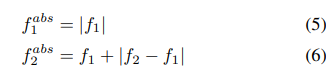

band_hz_ 초기값을 지금처럼 설정해두면, 첫번째 컨볼루션 필터의  f2 는 다음 두번째 컨볼루션 필터의  f1 이 됨 (diff로 계산한거여서 그런것같은데 맞나???)

이는 결과적으로 목표로 하는 주파수  f(16000)의 절반에 해당하는 범위(7900)에서 out_channels=80개의 컨볼루션 필터들이 비는 주파수 영역대가 없이 촘촘하게 입력 신호를 커버한다는 이야기임

(여기서 목표 주파수  f 의 절반의 범위에서 입력 신호를 커버하는 것은 나이퀴스트 정리(Nyquist Theorem)와 관련이 있는 것 같다 (ratsgo에 따르면))
* 나이퀴스트 정리: 원 신호를 목표 주파수로 복원하기 위해서는 해당 주파수 2배 이상의 sample rate로 샘플해야 한다는 정리

## 5. 해밍 윈도우 만들기

* 컨볼루션 필터(싱크 함수) 길이  L 에 절반에 해당하는 구간에 대해서만 해밍 윈도우를 만듦
* 해밍 윈도우는 함수 모양이 좌우 대칭(symmetric)이므로 절반만 만들어 놓고 이미 만든 절반(window_)과 이를 뒤집은 값들을 계산해 이어붙이면(concatnate) 같은 연산을 빠르게 수행 가능

In [32]:
n_lin = torch.linspace(0, (kernel_size / 2) - 1, steps=int((kernel_size / 2)))
window_ = 0.54 - 0.46 * torch.cos(2 * math.pi * n_lin / kernel_size)
n = (kernel_size - 1) / 2.0
n_ = 2 * math.pi * torch.arange(-n, 0).view(1, -1) / sample_rate

In [33]:
kernel_size

251

In [36]:
n_lin

tensor([  0.0000,   1.0040,   2.0081,   3.0121,   4.0161,   5.0202,   6.0242,
          7.0282,   8.0323,   9.0363,  10.0403,  11.0444,  12.0484,  13.0524,
         14.0565,  15.0605,  16.0645,  17.0685,  18.0726,  19.0766,  20.0806,
         21.0847,  22.0887,  23.0927,  24.0968,  25.1008,  26.1048,  27.1089,
         28.1129,  29.1169,  30.1210,  31.1250,  32.1290,  33.1331,  34.1371,
         35.1411,  36.1452,  37.1492,  38.1532,  39.1573,  40.1613,  41.1653,
         42.1694,  43.1734,  44.1774,  45.1814,  46.1855,  47.1895,  48.1936,
         49.1976,  50.2016,  51.2056,  52.2097,  53.2137,  54.2177,  55.2218,
         56.2258,  57.2298,  58.2339,  59.2379,  60.2419,  61.2460,  62.2500,
         63.2540,  64.2581,  65.2621,  66.2661,  67.2702,  68.2742,  69.2782,
         70.2823,  71.2863,  72.2903,  73.2944,  74.2984,  75.3024,  76.3064,
         77.3105,  78.3145,  79.3186,  80.3226,  81.3266,  82.3306,  83.3347,
         84.3387,  85.3427,  86.3468,  87.3508,  88.3548,  89.35

In [43]:
n_lin.shape, window_.shape, n, n_.shape

(torch.Size([125]), torch.Size([125]), 125.0, torch.Size([1, 125]))

In [38]:
window_

tensor([0.0800, 0.0801, 0.0806, 0.0813, 0.0823, 0.0836, 0.0852, 0.0871, 0.0893,
        0.0917, 0.0945, 0.0975, 0.1008, 0.1043, 0.1082, 0.1123, 0.1167, 0.1214,
        0.1263, 0.1315, 0.1369, 0.1426, 0.1485, 0.1547, 0.1612, 0.1679, 0.1748,
        0.1819, 0.1893, 0.1969, 0.2047, 0.2127, 0.2209, 0.2294, 0.2380, 0.2468,
        0.2558, 0.2650, 0.2743, 0.2838, 0.2935, 0.3034, 0.3134, 0.3235, 0.3338,
        0.3442, 0.3547, 0.3653, 0.3761, 0.3869, 0.3979, 0.4089, 0.4200, 0.4312,
        0.4425, 0.4538, 0.4652, 0.4766, 0.4881, 0.4996, 0.5111, 0.5227, 0.5342,
        0.5458, 0.5574, 0.5689, 0.5804, 0.5919, 0.6034, 0.6148, 0.6262, 0.6375,
        0.6488, 0.6600, 0.6711, 0.6822, 0.6931, 0.7040, 0.7147, 0.7254, 0.7359,
        0.7463, 0.7566, 0.7667, 0.7767, 0.7865, 0.7962, 0.8057, 0.8151, 0.8242,
        0.8332, 0.8421, 0.8507, 0.8591, 0.8673, 0.8753, 0.8832, 0.8907, 0.8981,
        0.9053, 0.9122, 0.9188, 0.9253, 0.9315, 0.9374, 0.9431, 0.9486, 0.9537,
        0.9587, 0.9633, 0.9677, 0.9718, 

In [41]:
n_

tensor([[-0.0491, -0.0487, -0.0483, -0.0479, -0.0475, -0.0471, -0.0467, -0.0463,
         -0.0459, -0.0456, -0.0452, -0.0448, -0.0444, -0.0440, -0.0436, -0.0432,
         -0.0428, -0.0424, -0.0420, -0.0416, -0.0412, -0.0408, -0.0404, -0.0401,
         -0.0397, -0.0393, -0.0389, -0.0385, -0.0381, -0.0377, -0.0373, -0.0369,
         -0.0365, -0.0361, -0.0357, -0.0353, -0.0350, -0.0346, -0.0342, -0.0338,
         -0.0334, -0.0330, -0.0326, -0.0322, -0.0318, -0.0314, -0.0310, -0.0306,
         -0.0302, -0.0298, -0.0295, -0.0291, -0.0287, -0.0283, -0.0279, -0.0275,
         -0.0271, -0.0267, -0.0263, -0.0259, -0.0255, -0.0251, -0.0247, -0.0243,
         -0.0240, -0.0236, -0.0232, -0.0228, -0.0224, -0.0220, -0.0216, -0.0212,
         -0.0208, -0.0204, -0.0200, -0.0196, -0.0192, -0.0188, -0.0185, -0.0181,
         -0.0177, -0.0173, -0.0169, -0.0165, -0.0161, -0.0157, -0.0153, -0.0149,
         -0.0145, -0.0141, -0.0137, -0.0134, -0.0130, -0.0126, -0.0122, -0.0118,
         -0.0114, -0.0110, -

# 6. 컷오프 주파수  f1 과  f2  만들기

여기서부터는 깃허브 코드에서 입력 음성 신호를 받아서 태스크(화자 인식) 수행에 적절한 방향으로  f1
 과  f2 를 갱신해 가는 파트다 !

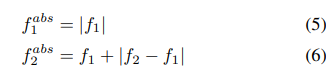

In [44]:
low = min_low_hz + torch.abs(low_hz_)
high = torch.clamp(input=low + min_band_hz + torch.abs(band_hz_),
                   min=min_low_hz,
                   max=sample_rate / 2)
band = (high - low)[:, 0]

* low (f1)은 앞서 만든 low_hz_의 절대값을 취해서 만듦
  * 이 때 위 수식과 다른 점은  min_low_hz=50을 더해준 것
* high (f2)는 low(f1)이고, torch.abs(band_hz_)가 아까 4번에서 구해둔 절대값임
  * 이 때 위 수식과 다른 점은 min_band_hz =50을 더해준 것
  * torch.clamp 함수는 입력이 min보다 작으면 min, max보다 크면 max, 그 사이이면 입력 그대로 리턴
* band는 추후를 위해 미리 짜둔 코드임 (싱크 함수를 대칭으로 만들기 위해 정의한 것)
  * 싱크 함수는 주로 통과시키는 주파수 영역대에서 최고치를 가짐

In [49]:
low.shape, high.shape

(torch.Size([80, 1]), torch.Size([80, 1]))

In [54]:
band.shape # torch.Size([80, 1])의 shape를 [:, 0]으로 바꾸어준거네 

torch.Size([80])

## 7. 싱크 함수 만들기 -1

수식 B. 이상적인 BANDPASS FILTER - 시간 도메인
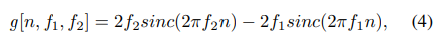

수식 B에서, 주파수( f )와 시간( t ), 샘플 인덱스( n )은 n=ft가 성립함 

수식 B를 계산하기 위해서는 수식 B의 n에 대응하는 값이 필요함 (=주파수(f)와 시간인덱스(t) 곱하기, torch.matmul)

In [58]:
low.shape, high.shape, n_.shape # 원래 값

(torch.Size([80, 1]), torch.Size([80, 1]), torch.Size([1, 125]))

In [61]:
# 여기서 n_ 는 앞서 5번에서 해밍윈도우를 만들때 진행한 코드로 다시 살펴보면 다음과 같음

n = (kernel_size - 1) / 2.0 # 125
n_ = 2 * math.pi * torch.arange(-n, 0).view(1, -1) / sample_rate

torch.arange(-n, 0).view(1, -1)을 수행하면 시간 인덱스 (t)에 대응하게 됨

이 벡터에 low, high를 내적한 결과가 수식B. 싱크 함수 내부에 있는 각각의  n이 됨

여기서 n_를 계산할 때, 2π(2 * math.pi)를 곱하고 sample_rate(f)로 나누어주었는데, 2π(2 * math.pi)는 싱크 함수 내에 있는 2π임 (4)

In [55]:
f_times_t_low = torch.matmul(low, n_)
f_times_t_high = torch.matmul(high, n_) # 계산 곱해보자 !

In [60]:
f_times_t_low.shape, f_times_t_high.shape # 결과값

(torch.Size([80, 125]), torch.Size([80, 125]))

## 8. 싱크함수 만들기 - 2

싱크 함수가  sinc(x)=sin(x)/x임을 고려하자

그러면,  이므로
시간 인덱스에  2π  가 이미 곱해진 n_에 2로 나눈 값을 다시 나눠주면 수식 B가 된다, -> 이게 무슨 뜻인지 아무리 봐도 모르겠다,, 일단 넘어가자

여기에 해밍윈도우를 곱한다 (5번)
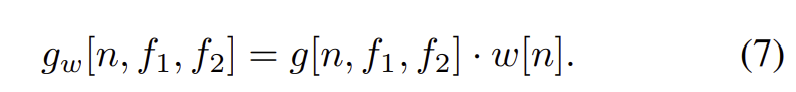

이것이 바로 컨볼루션 필터(싱크 함수)의 좌측 부분, 즉 band_pass_left이다

In [62]:
band_pass_left = ((torch.sin(f_times_t_high) - torch.sin(f_times_t_low)) / (n_ / 2)) * window_ # (4),(7)식을 실제로 수행한거네

In [63]:
band_pass_left.shape

torch.Size([80, 125])

이제, 좌우 대칭(symmetric)인 싱크 함수를 만들고 있으므로 이를 뒤집어(torch.flip) 오른쪽 부분인 (1) band_pass_right을 만들고 (2) 중간값(band_pass_center) 역시 만들 수 있다

In [64]:
band_pass_center = 2 * band.view(-1, 1)
band_pass_right = torch.flip(band_pass_left, dims=[1])

그 다음에 concat으로 다 합치는거구나, 이렇게 나누어서 cat하는 이유는 아까 얘기한대로 연산 줄이려고인거겠지.//
아무튼 최종적으로는 이를 이어붙여(concatenate) 필터 계산이 끝난다 !!!!!

In [65]:
band_pass = torch.cat([band_pass_left, band_pass_center, band_pass_right], dim=1)

In [66]:
band_pass.shape

torch.Size([80, 251])

In [67]:
band_pass = band_pass / (2 * band[:, None]) #  생성된 band_pass 텐서를 정규화 (필터를 정규화하여 특정 주파수 범위에서의 에너지를 보존하도록 함)

In [68]:
band_pass.shape

torch.Size([80, 251])

In [69]:
filters = (band_pass).view(out_channels, 1, kernel_size)

In [71]:
filters.shape # 우와 !!!!!!!!! 필터가 나왔다

torch.Size([80, 1, 251])

# 9. 필터는 어떻게 쓰일까?